1. Data Generation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
# w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
w_choice = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# # renormalization
# @tf.function
# def normalization(input_min, input_max, N, psi_Re, psi_Im):
#     dx = (input_max - input_min) / tf.cast(N, dtype=DTYPE)
#     norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
#     return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i, N_grid = 10000, 500, 500, 100

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled

psi_i = tf.cast(psi_init(x_i, w_choice, pi), tf.complex128)

# grid for normalization penalty
x_n = tf.linspace(x_min, x_max, N_grid)[:, None]
x_ns = scale_inputs(x_n, x_min, x_max)

In [2]:
# check shapes and data types
print('x_is')
print(tf.shape(x_is))
print(x_is.dtype)
print(tf.shape(t_is))
print(t_is.dtype)

print('x_bs')
print(tf.shape(x_bs))
print(x_bs.dtype)
print(tf.shape(t_bs))
print(t_bs.dtype)

print('x_fs')
print(tf.shape(x_fs))
print(x_fs.dtype)
print(tf.shape(t_fs))
print(t_fs.dtype)

print('psi_i')
print(tf.shape(psi_i))
print(psi_i.dtype)

print('x_ns')
print(tf.shape(x_ns))
print(x_ns.dtype)

x_is
tf.Tensor([500   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([500   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
x_bs
tf.Tensor([500   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([500   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
x_fs
tf.Tensor([10000     1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([10000     1], shape=(2,), dtype=int32)
<dtype: 'float64'>
psi_i
tf.Tensor([500   1], shape=(2,), dtype=int32)
<dtype: 'complex128'>
x_ns
tf.Tensor([100   1], shape=(2,), dtype=int32)
<dtype: 'float64'>


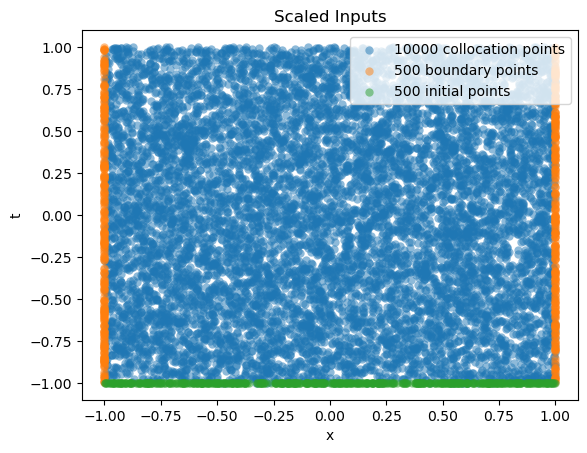

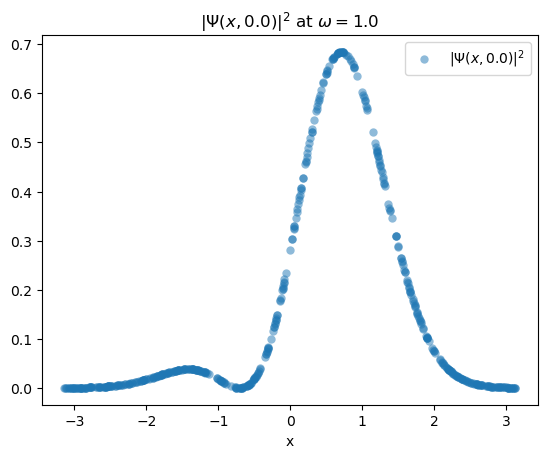

In [14]:
plt.scatter(x_fs, t_fs, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_bs, t_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, t_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

plt.scatter(x_i, tf.math.abs(psi_i)**2, alpha=0.5, linewidths=1e-6, label=f'$|\Psi(x,{float(t_i[0])})|^2$')
plt.xlabel('x')
plt.title(f'$|\Psi(x,{float(t_i[0])})|^2$ at $\omega={w_choice}$')
plt.legend(loc='upper right')
plt.show()

2. Model Architecture

In [19]:
# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=2, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            xs = scale_inputs(x, x_min, x_max)
            ts = scale_inputs(t, t_min, t_max)
            X = tf.concat([xs, ts], axis=1)
            # uv = tf.clip_by_value(model(X), -1e2, 1e2) # prevent extreme values
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x) #, unconnected_gradients='zero')
        v_x = tape1.gradient(v, x) #, unconnected_gradients='zero')
        u_t = tape1.gradient(u, t) #, unconnected_gradients='zero')
        v_t = tape1.gradient(v, t) #, unconnected_gradients='zero')
    u_xx = tape2.gradient(u_x, x) #, unconnected_gradients='zero')
    v_xx = tape2.gradient(v_x, x) #, unconnected_gradients='zero')
    del tape1, tape2

    potential = 0.5 * w_choice**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def norm_loss(model, x_ns, N_t):
    t_n = tf.random.uniform((N_t, 1), t_min, t_max, dtype=DTYPE)
    t_ns = scale_inputs(t_n, t_min, t_max)
    norm_penalty_total = 0.0
    for t_val in tf.unstack(t_ns, axis=0):
        t_in = tf.ones_like(x_ns) * t_val
        X = tf.concat([x_ns, t_in], axis=1)
        uv = model(X)
        dx = (x_max - x_min) / tf.cast(tf.shape(x_ns)[0], dtype=DTYPE)
        norm = tf.reduce_sum(tf.math.abs(uv)**2) * dx
        norm_penalty_total += tf.square(norm - 1.0)
    norm_penalty = norm_penalty_total / tf.cast(N_t, dtype=DTYPE)

    return norm_penalty

@tf.function
def loss_fn(model, interior, boundary, initial, norm_grid):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    x_grid, N_t = norm_grid

    f_u, f_v = pde_residual(model, x_f, t_f)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v)) # / tf.cast(tf.shape(x_f)[0], dtype=DTYPE)

    uv_b = model(tf.concat([x_b, t_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b[:, 0:1]) + tf.square(uv_b[:, 1:2])) # / tf.cast(tf.shape(x_b)[0], dtype=DTYPE)

    uv_i = model(tf.concat([x_i, t_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i))) # / tf.cast(tf.shape(x_i)[0], dtype=DTYPE)
    
    norm_penalty = norm_loss(model, x_grid, N_t)
    
    return loss_f + loss_b + loss_i + norm_penalty, (loss_f, loss_b, loss_i, norm_penalty)

In [16]:
# Create the model
model = PINN(input_dim=2, mapping_size=512, scale=10.0)

# Save the model in Keras format
model_test_path = 'model_test_w1.keras'
model.save(model_test_path)
print(f"Model saved to {model_test_path}")

# Load the model
loaded_model = tf.keras.models.load_model(model_test_path, custom_objects={'PINN': PINN})

# Dummy input to build the model (batch size 1, input_dim = 2)
dummy_input = tf.concat([x_f[:5], t_f[:5]], axis=1)
_ = loaded_model(dummy_input)

loaded_model.summary()

c:\Users\HP\anaconda3\Lib\site-packages\keras\src\saving\saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model saved to model_test_w1.keras


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_1         │ ?                      │         1,024 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (5, 512)               │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (5, 2)                 │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,818 (10.03 MB)

 Trainable params: 1,313,794 (10.02 MB)

 Non-trainable params: 1,024 (8.00 KB)

3. Optimizer and Step Function

In [20]:
# Define the Optimizer
# Learning rate schedule with exponential decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

# ADAM optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, x_n, N_t):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li, ln) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), (x_n, N_t))
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li, ln)

4. Training loop

Epoch 0: Loss = 1.16757e+02 (f = 1.000e+02, b = 5.820e-01, i = 4.683e-01, n = 1.567e+01)


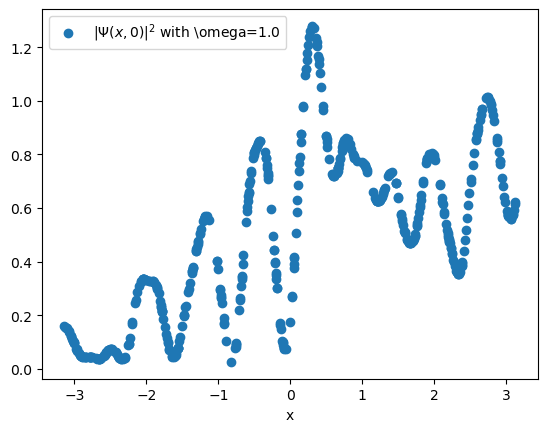

Best model saved to best_model_w1.keras at epoch 0 with loss 116.75701296577574


KeyboardInterrupt: 

In [21]:
# Instantiate the Model
pinn = PINN(input_dim=2, mapping_size=512, scale=10.0)

# pinn = tf.keras.models.load_model('best_model_s4v0.keras', custom_objects={'PINN': PINN})
# print("Model loaded successfully")

# Define the loss threshold
loss_threshold = 1e-10

# Early stopping
early_stopping_patience = 1000
best_loss = float('inf')
patience_counter = 0

# saving loss values
train_loss_results = {
    "total": [],
    "pde": [],
    "boundary": [],
    "initial": [],
    "norm" : []
}

# Start the timer
start_time = time.time()

best_model_path = "best_model_w1.keras"

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li, ln) = train_step(pinn, x_f, t_f, x_bs, t_bs, x_is, t_is, psi_i, x_ns, 3)

    train_loss_results["total"].append(loss.numpy())
    train_loss_results["pde"].append(lf.numpy())
    train_loss_results["boundary"].append(lb.numpy())
    train_loss_results["initial"].append(li.numpy())
    train_loss_results["norm"].append(ln.numpy())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy().item():.5e} (f = {lf.numpy().item():.3e}, b = {lb.numpy().item():.3e}, i = {li.numpy().item():.3e}, n = {ln.numpy().item():.3e})")

        X = tf.concat([x_is, t_is], axis=1)
        uv = pinn(X)
        u, v = uv[:, 0:1], uv[:, 1:2]
        # test_Re, test_Im = normalization(x_min, x_max, N_i, u, v)
        density = u**2 + v**2

        plt.scatter(x_i, density, label=r'$|\Psi(x,0)|^2$ with \omega=1.0')
        plt.xlabel('x')
        plt.legend()
        plt.show()
        
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience_counter = 0
        pinn.save(best_model_path)
        print(f"Best model saved to {best_model_path} at epoch {epoch} with loss {loss.numpy()}")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss.numpy()}")
        break
    
    if loss.numpy() < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss.numpy()}")
        break

    epoch += 1

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(train_loss_results["total"], label="Total Loss")
plt.plot(train_loss_results["pde"], label="PDE Loss")
plt.plot(train_loss_results["boundary"], label="Boundary Loss")
plt.plot(train_loss_results["initial"], label="Initial Loss")
plt.plot(train_loss_results["norm"], label="Norm Loss")
plt.yscale("log")
plt.legend()
plt.title("Loss Components During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(best_model_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")